In [125]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from typing import List, Union
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy']) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core.session import ProcessData

# Packages for Probe Configuration
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

# Ripples
from neuropy.analyses import oscillations

# Neurons
from neuropy.io import PhyIO
from neuropy.core import Neurons
from neuropy.core import BinnedSpiketrain
from neuropy.core.neurons import binned_pe_raster

from neuropy.analyses.spkepochs import detect_pbe_epochs
from neuropy.core import Epoch
from neuropy.io.openephysio import *

# Plotting
from neuropy.plotting import Fig
from neuropy.plotting import spikes
from neuropy.core.neurons import pe_raster



from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms

In [87]:
# Import Data Directory
basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1')
save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots')
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1/Creampuff_Homecage1.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3851.64 seconds 
duration: 1.07 hours 



In [91]:
# Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q = sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

neurons = sess.neurons

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


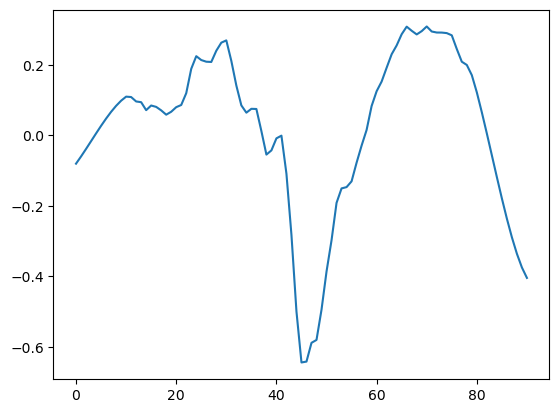

In [92]:
test = neurons.waveforms[41,0,:]
plt.plot(test)

In [90]:
# Metrics
trough_index = np.argmin(test)
a_ind = np.argmax(test[:trough_index])
b_ind = np.argmax(test[trough_index:]) + trough_index
zeroed_wf = (test[0] + test[-1]) / 2

a = test[a_ind] - zeroed_wf
b = test[b_ind] - zeroed_wf

# AB-Ratio
ab_ratio = (a - b) / (a + b) 
print(ab_ratio)

# Trough to Peak
print(b_ind)
print(trough_index)
print((b_ind - trough_index) / 90000)






-0.0371077164255076
70
45
0.0002777777777777778


In [189]:
ttp = []
ba_asymmetry = []
for i in range(neurons.waveforms.shape[0]):
    cur_wf = neurons.waveforms[i,0,:]
    t_idx = np.argmin(cur_wf)
    a_idx = np.argmax(cur_wf[:t_idx])
    b_idx = np.argmax(cur_wf[t_idx:]) + t_idx
    zeroed_wf = (cur_wf[0] + cur_wf[-1]) / 2

    a = cur_wf[a_idx] - zeroed_wf
    b = cur_wf[b_idx] - zeroed_wf

    ba_asymmetry.append((b - a) / (b + a))
    ttp.append((b_idx - t_idx) / 90000)

ttp = np.array(ttp)
ba_asymmetry = np.array(ba_asymmetry)

In [166]:
def calculate_neurons_acg(
    neurons: core.Neurons,
    bin_size=0.001,
    window_size=0.05,
    plot=True,
) -> np.ndarray:
    """Get autocorrelogram

    Parameters
    ----------
    spikes : [type], optional
        [description], by default None
    bin_size : float, optional
        [description], by default 0.001
    window_size : float, optional
        [description], by default 0.05
    """

    spikes = neurons.spiketrains

    correlo = []
    for cell in spikes:
        cell_id = np.zeros(len(cell)).astype(int)
        acg = correlograms(
            cell,
            cell_id,
            sample_rate=neurons.sampling_rate,
            bin_size=bin_size,
            window_size=window_size,
        ).squeeze()

        if acg.size == 0:
            acg = np.zeros(acg.shape[-1])

        correlo.append(acg)

    return np.array(correlo)

def acg_fit(x, a, b, c, d, e, f, g, h):
    """Approximation function to fit autocorrelograms of spike trains
    Equation obtained from:
    https://cellexplorer.org/pipeline/acg-fit/
    Parameters
    ----------
    x : _type_
        _description_
    a : float
        tau_decay
    b : float
        tau_rise
    c : float
        _description_
    d : float
        _description_
    e : float
        _description_
    f : float
        _description_
    g : float
        _description_
    h : float
        _description_

    Returns
    -------
    _type_
        _description_
    """
    eqtn = (
        c * (np.exp(-(x - f) / a) - d * np.exp(-(x - f) / b))
        + h * np.exp(-(x - f) / g)
        + e
    )
    return np.array([np.max([_, 0]) for _ in eqtn])


def acg_no_burst_fit(x, a, b, c, d, e, f):
    """Approximation function to fit autocorrelograms of spike trains
    Equation obtained from:
    https://cellexplorer.org/pipeline/acg-fit/
    Parameters
    ----------
    x : _type_
        _description_
    a : float
        tau_decay
    b : float
        tau_rise
    c : float
        _description_
    d : float
        _description_
    e : float
        _description_
    f : float
        _description_
    g : float
        _description_
    h : float
        _description_

    Returns
    -------
    _type_
        _description_
    """
    eqtn = c * (np.exp(-(x - f) / a) - d * np.exp(-(x - f) / b)) + e
    return np.array([np.max([_, 0]) for _ in eqtn])

In [169]:
type(acgs_good)

numpy.ndarray

In [190]:
mua_thresh = 20
all_neurons = [neurons]
spiketrains = np.concatenate([_.spiketrains for _ in all_neurons])
nspikes = np.array([len(_) for _ in spiketrains])
n_neurons = np.array([_.n_neurons for _ in all_neurons])

# ---- calculate acgs -------
acgs = np.vstack(
    [
        calculate_neurons_acg(_, bin_size=0.0005, window_size=0.1)
        for _ in all_neurons
    ]
)
acgs_max = acgs.max(axis=-1)  # max number of spikes in acg
acgs = acgs / nspikes.reshape(-1, 1) / 0.0005  # changing to rate
acgs_nbins = acgs.shape[-1]
acgs_center_indx = acgs_nbins // 2

acgs_right = acgs[:, acgs_center_indx + 1 :]
t_ccg_right = np.arange(acgs_right.shape[1])  # timepoints
mean_isi = np.sum(acgs_right * t_ccg_right, axis=1) / np.sum(acgs_right, axis=1)

frate = np.asarray([len(_) / np.ptp(_) for _ in spiketrains])

diff_auc = []
for neur in all_neurons:
    waveform = neurons.waveforms
    # Channels with maximum negative peak are considered peak channels are considered as the peak waveform representing the neuron
    peak_chan_indx = np.argmin(np.min(waveform, axis=2), axis=1)
    waveform = waveform[np.arange(waveform.shape[0]), peak_chan_indx, :]
    # waveform = np.asarray(
    #     [cell[np.argmax(np.ptp(cell, axis=1)), :] for cell in templates]
    # )

    n_t = waveform.shape[1]  # waveform width
    center = int(n_t / 2)
    wave_window = int(0.25 * (neur.sampling_rate / 1000))
    from_peak = int(0.18 * (neur.sampling_rate / 1000))
    left_peak = np.trapz(
        waveform[:, center - from_peak - wave_window : center - from_peak], axis=1
    )
    right_peak = np.trapz(
        waveform[:, center + from_peak : center + from_peak + wave_window], axis=1
    )

    diff_auc.append(left_peak - right_peak)
diff_auc = np.concatenate(diff_auc)

# ---- refractory contamination ----------
isi = np.concatenate([_.get_isi(bin_size=0.001, n_bins=100) for _ in all_neurons])
ref_nspikes = isi[:, :2].sum(axis=1)
violations = ref_nspikes * 100 / nspikes  # violation percent

mua_indx = violations > mua_thresh

# ----- selection LUA -----
# Excluding units which have very low number of spikes in autocorrelogram making it difficult for exponential fit
low_indx = acgs_max <= 5

good_indx = ~np.logical_or(mua_indx, low_indx)

# ----- fitting acgs and calculating parameters -----
acgs_good = acgs[good_indx, :]
ttp_good = ttp[good_indx]
ba_asymmetry_good = ba_asymmetry[good_indx]
acgs_good[:, 100:105] = 0  # making refractory period zero for better fitting
t = np.arange(0.5, 50.5, 0.5)  # timepoints for half acg

p_initial = [20, 1, 30, 2, 0.5, 5, 1.5, 0]

params = []
for y in acgs_good:
    lb = np.array([1, 0.1, -5, 0, -100, 0, 0.1, 0])
    ub = np.array([500, 50, 500, 25, 70, 20, 5, 100])

    try:
        popt, _ = curve_fit(
            acg_no_burst_fit,
            t,
            y[101:],
            p0=p_initial[:-2],
            bounds=(lb[:-2], ub[:-2]),
        )
    except:
        popt, _ = curve_fit(acg_fit, t, y[101:], p0=p_initial, bounds=(lb, ub))

    params.append(popt)
tau_decay = np.log10(np.array([_[0] for _ in params]))
tau_rise = np.array([_[1] for _ in params])

# ----- cluster classification ------
features = np.vstack(
    (
        frate[good_indx],
        mean_isi[good_indx],
        tau_decay,
        diff_auc[good_indx],
        tau_rise,
    )
).T
features = StandardScaler().fit_transform(features)
kmeans = KMeans(n_clusters=2, n_init=100).fit(features)
y_means = kmeans.predict(features)

# interneuron has higher firing rates
interneuron_label = np.argmax(kmeans.cluster_centers_[:, 1])
# interneuron_label = np.argmax(
#     [features[y_means == 0, 1].mean(), features[y_means == 1, 1].mean()]
# )
intneur_indx = np.where(y_means == interneuron_label)[0]
pyr_indx = np.where(y_means != interneuron_label)[0]

# ---- labeling -----
neuron_type = np.ones(np.sum(n_neurons), dtype="U5")
neuron_type[mua_indx] = "mua"  # multi unit activity
neuron_type[low_indx] = "lua"  # low unit activity
neuron_type[np.where(good_indx)[0][intneur_indx]] = "int"
neuron_type[np.where(good_indx)[0][pyr_indx]] = "pyr"

colors = np.ones(np.sum(n_neurons), dtype=object)
colors[neuron_type == "mua"] = "#bcb8b8"
colors[neuron_type == "lua"] = "#D50000"
colors[neuron_type == "int"] = "#5da42d"
colors[neuron_type == "pyr"] = "#212121"

Text(0, 0.5, 'Peak Asymmetry')

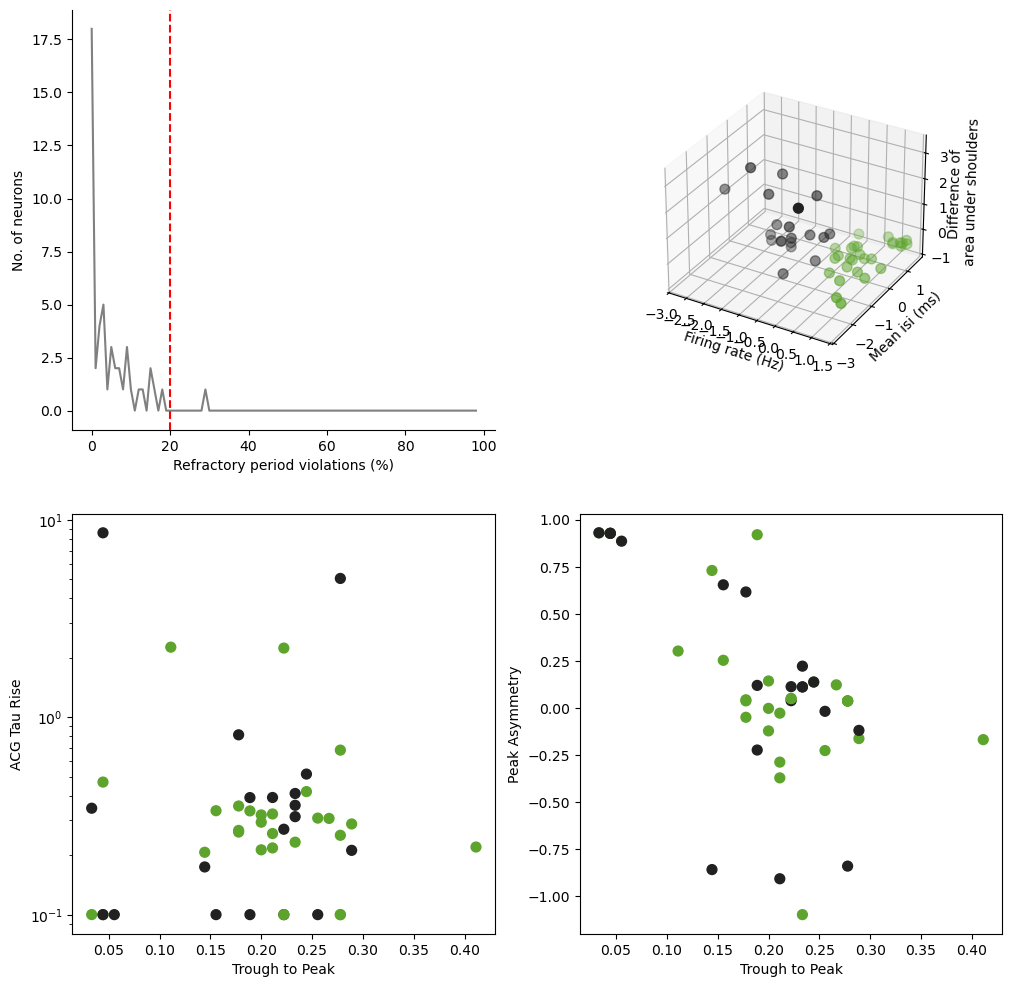

In [196]:
fig = plt.figure()
fig.set_size_inches([12,12])

ax1 = fig.add_subplot(221)
bins = np.arange(0, 100, 1)
ax1.plot(bins[:-1], np.histogram(violations, bins=bins)[0], "gray")
ax1.axvline(mua_thresh, ls="--", color="r")
ax1.set_xlabel("Refractory period violations (%)")
ax1.set_ylabel("No. of neurons")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2 = fig.add_subplot(222, projection="3d")
ax2.scatter(
    features[:, 1], features[:, 2], features[:, 3], c=list(colors[good_indx]), s=50
)

ax2.set_xlabel("Firing rate (Hz)")
ax2.set_ylabel("Mean isi (ms)")
ax2.set_zlabel("Difference of \narea under shoulders")
ax2.set_box_aspect(None, zoom=0.7)

ax3 = fig.add_subplot(223)
ax3.scatter(ttp_good * 1000, tau_rise, c=list(colors[good_indx]),s=50)
ax3.set_yscale('log')  # Setting y-axis to exponential (logarithmic scale)
ax3.set_xlabel("Trough to Peak")
ax3.set_ylabel("ACG Tau Rise")

ax4 = fig.add_subplot(224)
ax4.scatter(ttp_good * 1000, ba_asymmetry_good, c=list(colors[good_indx]),s=50)
ax4.set_xlabel("Trough to Peak")
ax4.set_ylabel("Peak Asymmetry")